In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import seaborn as sns

In [3]:
%config IPCompleter.greedy=True

In [4]:
class MLP_new:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len,
                 acti_funs,acti_funs_grad,cost_fun,cost_fun_grad,seed=123, problem=""):
        
        np.random.seed(seed)
        
        self.acti_funs=acti_funs
        self.acti_funs_grad=acti_funs_grad
        
        self.cost_fun=cost_fun
        self.cost_fun_grad=cost_fun_grad
        
        if problem=="classification" or problem=="C":
            self.acti_funs=self.acti_funs+[softmax]
            self.acti_funs_grad=self.acti_funs_grad+[softmax_grad]
            
        if problem=="regression" or problem=="R":
            self.acti_funs=self.acti_funs+[identity]
            self.acti_funs_grad=self.acti_funs_grad+[identity_grad]
            
        
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.output_before =np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.acti_funs[i](self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.acti_funs[i](self.weights[i].dot(input_layer)+self.biases[i])
                
        
       
        output_layer=self.acti_funs[-1](self.weights[-1].dot(input_layer)+self.biases[-1])
        self.output_before=(self.weights[-1].dot(input_layer)+self.biases[-1]).T
        self.output_layer=output_layer.T
        
        return(output_layer.T)
        
    def train(self,train_input_layer,train_output_layer,max_epoch=2000,rate=0.1,beta=0,batch=1,stop=10**-6,RMSprop=False,L1=False,L2=False,eps=10**-8,alpha=0.01,
              validate=False,early_stop=3,test_input_layer=0,test_output_layer=0,return_error_list=True,return_gradients=False,Verbose=True):
    
        #creating batches
        lin=np.linspace(0,train_input_layer.shape[0],int(1/batch)+1).round().astype(int)
        #initiating errors
        output_layer=self.calculate(train_input_layer)
        error=self.cost_fun(train_output_layer,output_layer)
        #initiating early stopping
        warning=0
        if validate:
            output_layer=self.calculate(test_input_layer)
            error_test=self.cost_fun(test_output_layer,output_layer)
        
        print("start error "+str(error))
        #initiating old gradient list
        old_grad=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_grad_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]
        
        
        for epoch in range(1,max_epoch+1):
            
            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]
                
                #backpropagate errors
                for x in range(batch_size):
                    #all cost funs should be independent from size of vectors because we rescale them later
                    #last acti fun is used at output_layer so for classification it should be softmax and for regresion identity
                    errors[x][-1]=((self.cost_fun_grad(train_output_layer[lin[b]:lin[b+1]][x:x+1],output_layer[x:x+1]))*self.acti_funs_grad[-1](self.output_before[x:x+1])).T
                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*self.acti_funs_grad[i](self.hidden_layers[i][:,x:x+1])
                
                #calculate gradients
                for l in range(1,len(self.weights)):
                    #we rescale by batch size here
                    #new_grad=np.clip(new_grad,-10**6,10**6) is used to prevent weights exploding
                    #we update grads beta here is momentum
                    if(RMSprop):
                        new_grad=sum([errors[x][l].dot(self.acti_funs[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        #regularization
                        if L1:
                            new_grad+=alpha*np.sign(self.weights[l])#/batch_size
                        elif L2:
                            new_grad+=alpha*self.weights[l]#/batch_size
                        #updating gradients
                        old_grad[l][b]=beta*old_grad[l][b]+(1-beta)*new_grad**2
                        self.weights[l]=self.weights[l]-new_grad*(rate/(np.sqrt(old_grad[l][b])+eps))

                        new_grad_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        old_grad_bias[l][b]=beta*old_grad_bias[l][b]+(1-beta)*new_grad_bias**2
                        self.biases[l]=self.biases[l]-new_grad_bias*(rate/(np.sqrt(old_grad_bias[l][b])+eps))
                    else:
                        new_grad=sum([errors[x][l].dot(self.acti_funs[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        if L1:
                            new_grad+=alpha*np.sign(self.weights[l])#/batch_size
                        elif L2:
                            new_grad+=alpha*self.weights[l]#/batch_size
                        new_grad=beta*old_grad[l][b]+(1-beta)*new_grad
                        old_grad[l][b]=new_grad
                        self.weights[l]=self.weights[l]-new_grad*rate

                        new_grad_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                        new_grad_bias=beta*old_grad_bias[l][b]+(1-beta)*new_grad_bias
                        old_grad_bias[l][b]=new_grad_bias
                        self.biases[l]=self.biases[l]-new_grad_bias*rate
                
                #calculate gradient for input layer
                if(RMSprop):
                    new_grad=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_grad=np.clip(new_grad,-10**6,10**6)
                    if L1:
                        new_grad+=alpha*np.sign(self.weights[0])#/batch_size
                    elif L2:
                        new_grad+=alpha*self.weights[0]#/batch_size
                    old_grad[0][b]=beta*old_grad[0][b]+(1-beta)*new_grad**2
                    self.weights[0]=self.weights[0]-new_grad*(rate/(np.sqrt(old_grad[0][b])+eps))

                    new_grad_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                    old_grad_bias[0][b]=beta*old_grad_bias[0][b]+(1-beta)*new_grad_bias**2
                    self.biases[0]=self.biases[0]-new_grad_bias*(rate/(np.sqrt(old_grad_bias[0][b])+eps))
                else:
                    new_grad=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_grad=np.clip(new_grad,-10**6,10**6)
                    if L1:
                        new_grad+=alpha*np.sign(self.weights[0])#/batch_size
                    elif L2:
                        new_grad+=alpha*self.weights[0]#/batch_size
                    new_grad=beta*old_grad[0][b]+(1-beta)*new_grad
                    old_grad[0][b]=new_grad
                    self.weights[0]=self.weights[0]-new_grad*rate

                    new_grad_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                    new_grad_bias=beta*old_grad_bias[0][b]+(1-beta)*new_grad_bias
                    old_grad_bias[0][b]=new_grad_bias
                    self.biases[0]=self.biases[0]-new_grad_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=self.cost_fun(train_output_layer,output_layer)
            
            #check stopping conditions if worse early_stop a row then stop
            if validate:
                output_layer=self.calculate(test_input_layer)
                new_error_test=self.cost_fun(test_output_layer,output_layer)
                if new_error_test>error_test:
                    if warning>=early_stop:
                        break
                    else:
                        error_test=new_error_test
                        warning+=1
                else:
                    error_test=new_error_test
                    warning=0
                
            if return_error_list:
                error_list.append(new_error)
            
            if(epoch % 100 == 0 and Verbose):
                print("epoch "+str(epoch))
                
            if new_error<=0:
                break
            
            if ((abs(new_error-error)/error)<stop).all():
                break

            error=new_error
        
        print("end in epoch "+str(epoch)+ " with error "+str(new_error))
        if return_error_list:
            return error_list
        elif return_gradients:
            return old_grad, old_grad_bias
        else:
            return new_error

In [5]:
def softmax(z):
    e = np.exp(z)
    return e / np.sum(e, axis=0,keepdims=True)

In [6]:
def softmax_grad(s):
    s=softmax(s.T)
    return (s*(1-s)).T   

In [7]:
def ReLU(x):
    return x * (x > 0)

In [8]:
def ReLU_grad(x):
    return 1. * (x > 0)

In [9]:
def tanh(z):
    e = np.exp(2*z)
    return 1-2/(e+1)

In [10]:
def tanh_grad(z):
    return 1-tanh(z)**2

In [11]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

In [12]:
def MSE_grad(Y,Y_hat):
     return Y_hat-Y

In [13]:
def MAE(Y,Y_hat):
    return np.sum(np.abs(Y-Y_hat))

In [14]:
def MAE_grad(Y,Y_hat):
    return (Y_hat>=Y)*2-1

In [15]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [16]:
def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [17]:
def cross_entropy(targets,predictions,  epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    ce = abs(np.sum(targets*np.log(predictions)))
    return ce


In [18]:
def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [19]:
def identity(x):
    return x

In [20]:
def identity_grad(x):
    return 1

# MNIST

In [21]:
from sklearn.decomposition import PCA

In [230]:
test = np.loadtxt("MNIST/train.csv", delimiter=',', skiprows=1, usecols=range(0,785))
np.random.shuffle(test)
X=test[:,1:785]
Y=test[:,0:1]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=X/255
train_output_layer=Y

In [231]:
test = np.loadtxt("MNIST/test.csv", delimiter=',', skiprows=1, usecols=range(0,784))
np.random.shuffle(test)
X1=test[:,0:784]
test_input_layer=X1/255

In [232]:
L=[64,64]
mlp_test2=MLP_new(784,10,L,[tanh]*len(L),[tanh_grad]*len(L),cross_entropy,cross_entropy_grad,problem="C",seed=123)

In [233]:
start_time = time.time()
er=mlp_test2.train(train_input_layer,train_output_layer,max_epoch=1200,Verbose=True,beta=0.9,batch=0.05)
end_time = time.time()
t=end_time - start_time
print(str(round(t/60))+" minutes")
    
output_layer=mlp_test2.calculate(train_input_layer)
score_train=cross_entropy(train_output_layer,output_layer)/output_layer.shape[0]

accuracy_train=round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)
print("accuracy_train "+str(accuracy_train))

output_layer=mlp_test2.calculate(test_input_layer)

start error 263535.401168552
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900
epoch 1000
epoch 1100
epoch 1200
end in epoch 1200 with error 2845.0182058937567
195 minutes
accuracy_train 0.984


ValueError: shapes (64,784) and (300,21000) not aligned: 784 (dim 1) != 300 (dim 0)

In [240]:
output_layer=mlp_test2.calculate(test_input_layer)

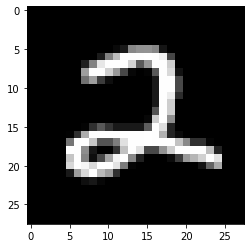

In [225]:
plt.imshow(np.array(X[1,:]).reshape(28,28),cmap='gray')

# PCA to save time Validation and L2 to prevent overfitting

In [22]:
test = np.loadtxt("MNIST/train.csv", delimiter=',', skiprows=1)
np.random.seed(123)
np.random.shuffle(test)
X=test[:,1:]
Y=test[:,0:1]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=X/255
pca=PCA(n_components=300)
pca=pca.fit(X)
train_input_layer=pca.transform(X[::2,:])
train_output_layer=Y[::2,:]
validate_input=pca.transform(X[1::2,:])
validate_output=Y[1::2,:]

In [23]:
test = np.loadtxt("MNIST/test.csv", delimiter=',', skiprows=1)
X1=test
test_input_layer=X1/255
test_input_layer=pca.transform(test_input_layer)

In [24]:
L=[64,64]
mlp_test=MLP_new(300,10,L,[tanh]*len(L),[tanh_grad]*len(L),cross_entropy,cross_entropy_grad,problem="C",seed=123)

In [25]:
start_time = time.time()
er=mlp_test.train(train_input_layer,train_output_layer,max_epoch=1200,Verbose=True,beta=0.9,batch=0.05,validate=True, early_stop=10, test_input_layer=validate_input,test_output_layer=validate_output,L2=True,alpha=0.01)
end_time = time.time()
t=end_time - start_time
print(str(round(t/60))+" minutes")
    
output_layer=mlp_test.calculate(train_input_layer)
score_train=cross_entropy(train_output_layer,output_layer)/output_layer.shape[0]

accuracy_train=round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)
print("accuracy_train "+str(accuracy_train))

output_layer=mlp_test.calculate(validate_input)
score_validate=cross_entropy(validate_output,output_layer)/output_layer.shape[0]

accuracy_validate=round(np.mean(np.argmax(validate_output,axis=1)==np.argmax(output_layer,axis=1)),3)
print("accuracy_validate "+str(accuracy_validate))

output_layer=mlp_test.calculate(test_input_layer)

start error 148944.94132982014
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900
epoch 1000
epoch 1100
epoch 1200
end in epoch 1200 with error 4881.672218677337
45 minutes
accuracy_train 0.945
accuracy_validate 0.934


In [28]:
score_train

0.23246058184177795

In [27]:
score_validate

0.26175895548278344

In [26]:
np.savetxt("hidden1",mlp_test.hidden_layers[0])
np.savetxt("hidden2",mlp_test.hidden_layers[1])
np.savetxt("bias1",mlp_test.biases[0])
np.savetxt("bias2",mlp_test.biases[1])

In [241]:
df = pd.DataFrame(
{"ImageId" : np.arange(1,output_layer.shape[0]+1),
"Label" : np.argmax(output_layer,axis=1)},
index = None)

In [242]:
df.to_csv("submition3.csv",sep=",",index=False)

<AxesSubplot:ylabel='Frequency'>

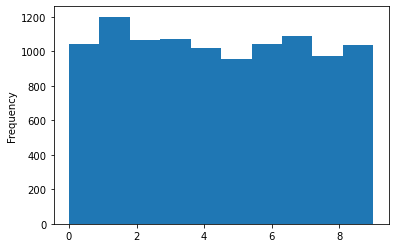

In [146]:
df.Label.plot.hist()